In [10]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

In [11]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data

Get the data from GitHub

In [12]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-2/main/listings.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,NaN,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.48
1,40625,https://www.airbnb.com/rooms/40625,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.85 · 2 bedrooms · 4...,NaN,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.59,4.72,NaN,t,15,14,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,NaN,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.59,NaN,f,3,3,0,0,2.36
3,70637,https://www.airbnb.com/rooms/70637,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.75
4,75500,https://www.airbnb.com/rooms/75500,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.45 · 2 bedrooms · 2...,NaN,NaN,https://a0.muscache.com/pictures/549090/b51ce4...,400857,...,4.67,4.08,4.42,NaN,f,1,1,0,0,0.08


## Cleaning

Make dummifier function, to be able to make 1/0 booleans

In [13]:
# Def "dummifier" function

# For self-created dummies (True/False)
def todummy(b):
    if b == True or b == "t":
        return 1
    return 0

Cleaning the dataset:
- Declare the company's request (2-6 people, apartment etc.)
- Dropping NAs for price
- Making flag variables
- Creating dummy variables with the function

In [14]:
# Only 2-6 people accommodations
data = data.loc[data["accommodates"].between(2,6)]


# Exclude Hotel rooms
data = data.loc[data["room_type"] != "Hotel room"]


# Only Rental unit or condo(basically apartment)
data = data[data["property_type"].str.contains("Entire rental unit|Private room in rental unit|Entire condo|Private room in condo") == True]

# Drop rows, where the price is missing (NAN)
data = data.dropna(subset=["price"])


# Replace currency price to float
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)

# Get rid of very high/absurd values
data = data.loc[data["price"] < 350]


#Flags

# Has review (more than 0)
data["flag_number_of_reviews"] = data["number_of_reviews"] > 0

# Has a score of at least 3.5
data["flag_review_scores_rating"] = (data["review_scores_rating"] >= 3.5)


# Replace booleans to 1/0, so the program will be able to use it

data["flag_number_of_reviews"] = data["flag_number_of_reviews"].apply(todummy)
print(data["flag_number_of_reviews"].value_counts())
data["flag_review_scores_rating"] = data["flag_review_scores_rating"].apply(todummy)
print(data["flag_review_scores_rating"].value_counts())


data["host_is_superhost"] = data["host_is_superhost"].apply(todummy)
print(data["host_is_superhost"].value_counts())
data["host_has_profile_pic"] = data["host_has_profile_pic"].apply(todummy)
print(data["host_has_profile_pic"].value_counts())
data["host_identity_verified"] = data["host_identity_verified"].apply(todummy)
print(data["host_identity_verified"].value_counts())
data["instant_bookable"] = data["instant_bookable"].apply(todummy)
print(data["instant_bookable"].value_counts())


flag_number_of_reviews
1    8156
0    1270
Name: count, dtype: int64
flag_review_scores_rating
1    8001
0    1425
Name: count, dtype: int64
host_is_superhost
0    6359
1    3067
Name: count, dtype: int64
host_has_profile_pic
1    9064
0     362
Name: count, dtype: int64
host_identity_verified
1    8877
0     549
Name: count, dtype: int64
instant_bookable
1    4985
0    4441
Name: count, dtype: int64


Based on the cleaning, declare the variables, that the models will use

In [15]:
# Declare variables that will be used

# basic variables
basic_vars = [
    "accommodates", 
    "beds", 
    "property_type", 
    "room_type", 
    "bathrooms_text",
    "neighbourhood_cleansed", 
]

# reviews
reviews = [
    "number_of_reviews", 
    "flag_number_of_reviews", 
    "review_scores_rating",
    "flag_review_scores_rating",
]

# host dummy variables + instant_bookable dummy
host = [
    "host_is_superhost", 
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable", 
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type", 
    "room_type:property_type", 
    "room_type:instant_bookable",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed", 
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host
predictors_E = basic_vars + reviews + host + X1 + X2

Drop those missing values that are in those variables, that will be used

In [16]:
# Check for columns with NA values and drop them
for i in predictors_2:
    if data[i].isna().sum() > 0:
        data = data.dropna(subset=[i])

# 3 Different models:
- Linear OLS regression
- Random Forest
- LASSO

Split the data to a train and test (holdout) set 1:3 ratio

In [17]:
#train and test data
data_train, data_holdout = train_test_split(data, train_size=0.75, random_state=42)
data_train.shape, data_holdout.shape

((6007, 77), (2003, 77))

## OLS
Using the Ordinary Least Squares regression with the 2nd predictors variable (basic + reviews + host)

In [18]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

41.72144010532171

In [19]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [20]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-0.000
property_type[T.Entire rental unit],2.880
property_type[T.Private room in condo],-15.930
property_type[T.Private room in rental unit],-10.176
room_type[T.Private room],-26.106
bathrooms_text[T.1 bath],-15.584
bathrooms_text[T.1 private bath],26.209
bathrooms_text[T.1 shared bath],-7.869
bathrooms_text[T.1.5 baths],-7.462
bathrooms_text[T.1.5 shared baths],-3.995


## Random Forest

### RF Model
Using the same predictors as the OLS model, but RF will choose the best combinations

In [21]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [22]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 7.28.


In [23]:
rfr = RandomForestRegressor(random_state = 20240129)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [24]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-42.481 total time=   0.5s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-43.622 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-41.161 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-40.424 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-42.670 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-43.310 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-44.078 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-42.245 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-41.481 total time=   0.3s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-43.691 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-44.075 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=15;, score=-44.439 total time=   0.

In [25]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-42.071633
1,6,10,-42.960918
2,6,15,-43.515501
3,8,5,-41.702056
4,8,10,-42.458598
5,8,15,-42.961762
6,10,5,-41.613232
7,10,10,-42.202179
8,10,15,-42.743648
9,12,5,-41.490931


In [26]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,42.07,42.96,43.52
8,41.70,42.46,42.96
10,41.61,42.20,42.74
12,41.49,42.07,42.54


In [27]:
print("Best Score:",rf_model.best_score_)
print("Best Parameters:",rf_model.best_params_)
rf_model.best_estimator_

Best Score: -41.490931427592514
Best Parameters: {'max_features': 12, 'min_samples_leaf': 5}


RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

### Diagnostic: Feature importances

In [28]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.22479339e-02, 1.24753573e-03, 2.92196851e-02,
       6.03177606e-02, 2.23005667e-02, 4.27462478e-03, 9.81462114e-03,
       1.75142979e-02, 1.94306051e-03, 3.07115195e-02, 1.01462187e-04,
       2.88298874e-02, 1.76403565e-04, 0.00000000e+00, 2.99038372e-05,
       0.00000000e+00, 6.45775513e-07, 7.79245609e-05, 0.00000000e+00,
       0.00000000e+00, 4.31409269e-03, 2.57090997e-03, 3.88818456e-04,
       6.52692147e-03, 1.74100112e-03, 4.09032470e-03, 3.32211923e-03,
       1.52723000e-01, 1.36698611e-02, 1.68405191e-02, 8.36762725e-03,
       7.46267392e-05, 3.83756344e-03, 7.91656355e-03, 3.67294277e-03,
       5.45877669e-03, 6.90536915e-03, 2.95589189e-03, 1.40123273e-02,
       2.45737544e-03, 1.19130021e-02, 1.53348211e-03, 1.91911880e-01,
       6.13188938e-02, 1.03461417e-01, 0.00000000e+00, 9.12134059e-02,
       1.58666698e-03, 2.69076330e-02, 2.15979716e-03, 1.72818307e-03,
       2.56111743e-02])

In [29]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000e+00
property_type[T.Entire rental unit],1.224793e-02
property_type[T.Private room in condo],1.247536e-03
property_type[T.Private room in rental unit],2.921969e-02
room_type[T.Private room],6.031776e-02
bathrooms_text[T.1 bath],2.230057e-02
bathrooms_text[T.1 private bath],4.274625e-03
bathrooms_text[T.1 shared bath],9.814621e-03
bathrooms_text[T.1.5 baths],1.751430e-02
bathrooms_text[T.1.5 shared baths],1.943061e-03


In [30]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,19.2%,19.2%
1,neighbourhood_cleansed[T.Innere Stadt],15.3%,34.5%
2,number_of_reviews,10.3%,44.8%
3,review_scores_rating,9.1%,53.9%
4,beds,6.1%,60.1%
5,room_type[T.Private room],6.0%,66.1%
6,bathrooms_text[T.2 baths],3.1%,69.2%
7,property_type[T.Private room in rental unit],2.9%,72.1%
8,bathrooms_text[T.2.5 baths],2.9%,75.0%
9,host_is_superhost,2.7%,77.7%


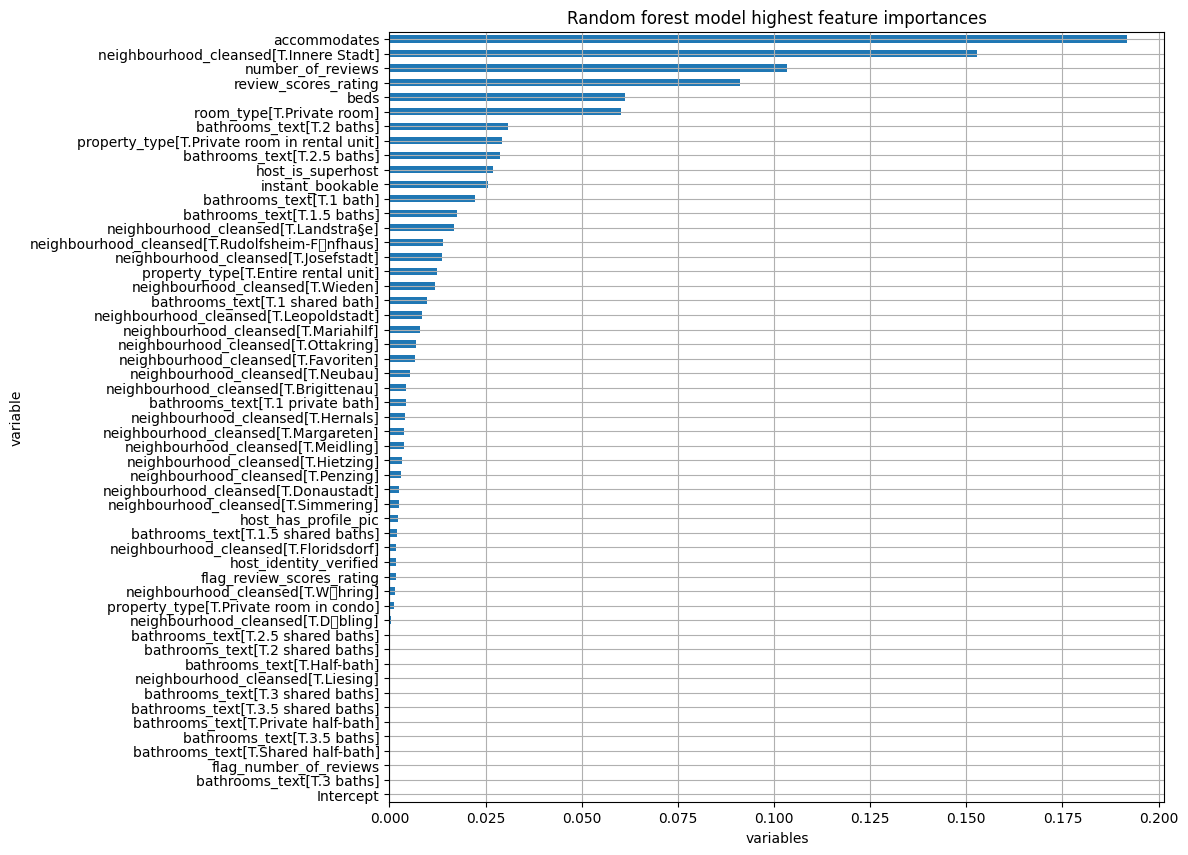

In [31]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

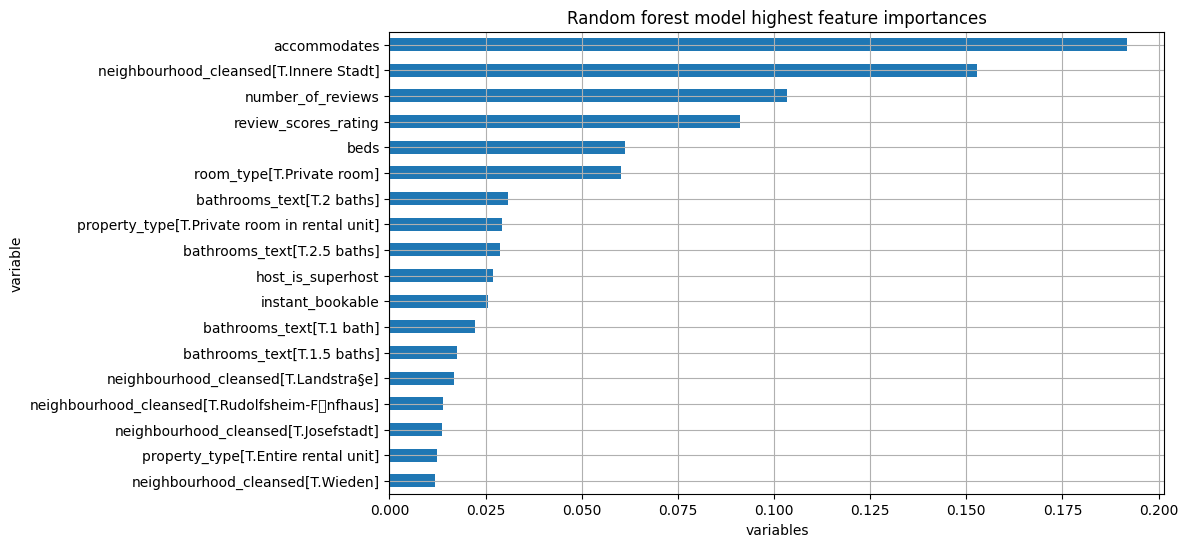

In [32]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [33]:
categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [34]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 3.62 s
Wall time: 3.8 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bathrooms_text',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews',
                                                   'flag_number_of_reviews',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'instant_bookable'])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

In [35]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 6.58 s
Wall time: 6.74 s


In [36]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.177325
beds,0.014703
property_type,0.007063
room_type,0.045287
bathrooms_text,0.050130
neighbourhood_cleansed,0.188059
number_of_reviews,0.044198
flag_number_of_reviews,0.000000
review_scores_rating,0.030024
flag_review_scores_rating,-0.000559


In [37]:
grouped = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]

df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,18.8%,18.8%
1,accommodates,17.7%,36.5%
2,bathrooms_text,5.0%,41.6%
3,room_type,4.5%,46.1%
4,beds,1.5%,47.6%
5,property_type,0.7%,48.3%


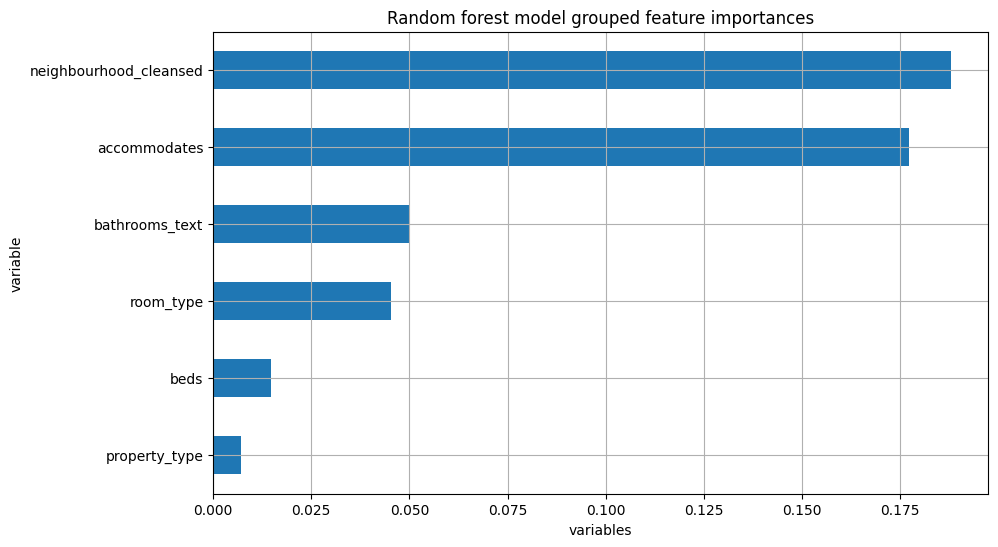

In [38]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [39]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,0.188059,0.191912
1,accommodates,0.177325,0.344635
2,bathrooms_text,0.050130,0.448096
3,room_type,0.045287,0.539310
4,number_of_reviews,0.044198,0.600629
5,instant_bookable,0.034046,0.660946
6,review_scores_rating,0.030024,0.691658
7,host_is_superhost,0.019271,0.720878
8,beds,0.014703,0.749707
9,property_type,0.007063,0.776615


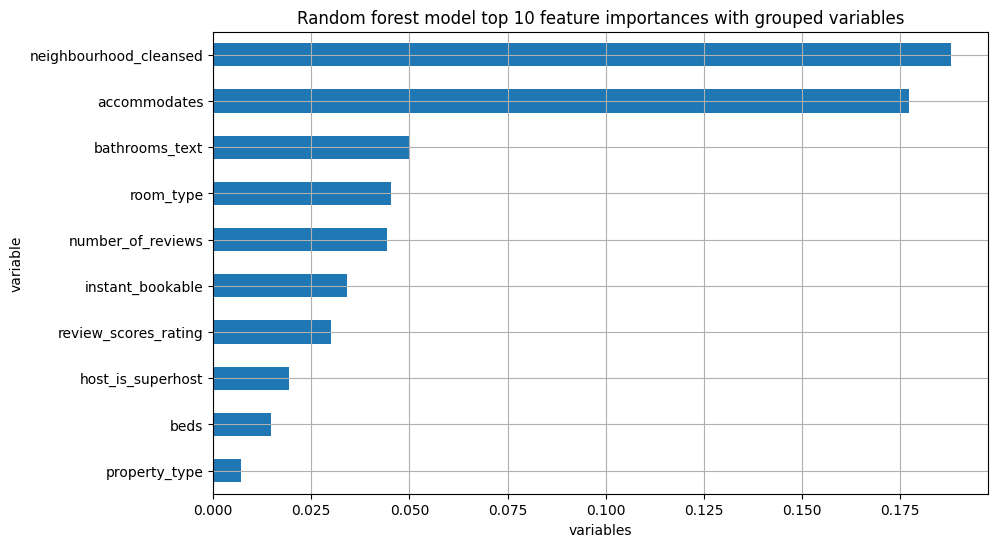

In [40]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

In [41]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

accomodates_pdp

{'grid_values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'average': array([[ 91.90748854,  94.68621842, 106.9892639 , 120.54329095,
         131.3506119 ]])}

In [42]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,91.907489
1,3,94.686218
2,4,106.989264
3,5,120.543291
4,6,131.350612


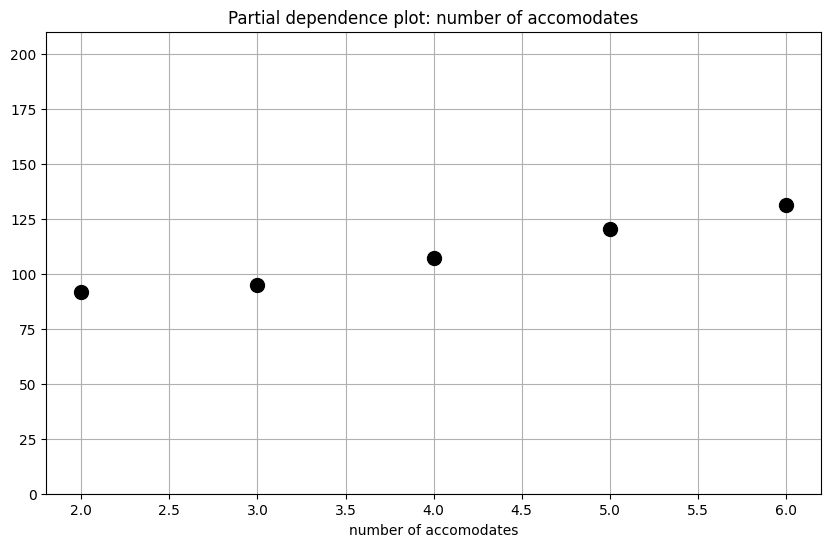

In [43]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: number of accomodates'
);

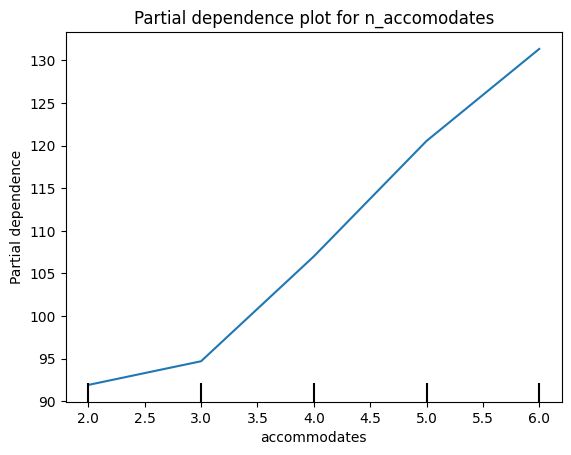

In [44]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(2, 6, num=5)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

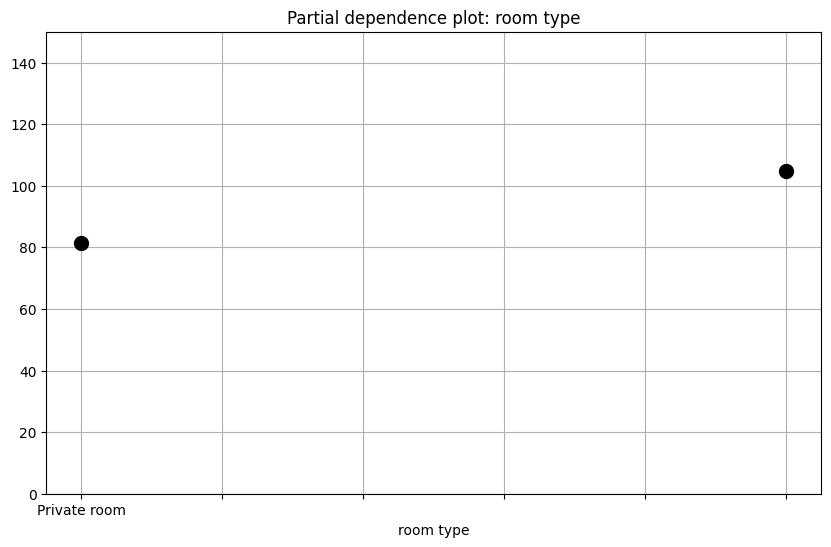

In [45]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["room_type"], kind="average"
)

pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 150), 
    title = 'Partial dependence plot: room type'
);

### Subsample Performance

In [46]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

#### Apartment Size

In [47]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

data_holdout_w_prediction.iloc[0:5, -5:]

,reviews_per_month,flag_number_of_reviews,flag_review_scores_rating,predicted_price,is_low_size
918,2.83,1,1,83.924462,small apt
12270,3.51,1,1,117.894395,large apt
6498,0.69,1,1,98.873139,large apt
12657,4.43,1,1,117.010872,large apt
5580,0.04,1,1,132.587379,large apt


In [48]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    41.905236
small apt    32.757086
dtype: float64

In [49]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )


# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,43.53,119.20,0.37
small apt,33.69,85.79,0.39


#### Fancy Neighbourhoods

In [50]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.neighbourhood_cleansed.isin(
        [
            "Innere Stadt",
            "Leopoldstadt",
            "Wieden",
            "Landstra§e",
        ]
    )
].groupby("neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

,rmse,mean_price,rmse_norm
neighbourhood_cleansed,,,
Innere Stadt,54.43,169.19,0.32
Landstra§e,45.88,112.42,0.41
Leopoldstadt,36.14,102.37,0.35
Wieden,47.60,120.50,0.39


#### Property Type

In [51]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.property_type.isin(["Entire rental unit", "Private room in rental unit", "Entire condo", "Private room in condo"])
].groupby("property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

,rmse,mean_price,rmse_norm
property_type,,,
Entire condo,39.25,96.04,0.41
Entire rental unit,39.55,107.30,0.37
Private room in condo,38.65,67.96,0.57
Private room in rental unit,29.89,64.04,0.47


In [52]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,38.78,102.0,0.38


#### Performance

In [53]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

type_rows

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
Type,------,------,------
Borough,------,------,------
------,------,------,------


In [54]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
large apt,43.53,119.2,0.37
small apt,33.69,85.79,0.39
Type,------,------,------
Entire condo,39.25,96.04,0.41
Entire rental unit,39.55,107.3,0.37
Private room in condo,38.65,67.96,0.57
Private room in rental unit,29.89,64.04,0.47
Borough,------,------,------
Innere Stadt,54.43,169.19,0.32


## LASSO

In [55]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [56]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-42.825 total time=   0.0s


[CV 2/5] END ......................alpha=0.05;, score=-43.780 total time=   0.1s
[CV 3/5] END ......................alpha=0.05;, score=-41.026 total time=   0.0s
[CV 4/5] END ......................alpha=0.05;, score=-40.102 total time=   0.0s
[CV 5/5] END ......................alpha=0.05;, score=-42.714 total time=   0.0s
[CV 1/5] END .......................alpha=0.1;, score=-42.957 total time=   0.0s
[CV 2/5] END .......................alpha=0.1;, score=-43.721 total time=   0.0s
[CV 3/5] END .......................alpha=0.1;, score=-41.069 total time=   0.0s
[CV 4/5] END .......................alpha=0.1;, score=-40.368 total time=   0.0s
[CV 5/5] END .......................alpha=0.1;, score=-42.851 total time=   0.0s
[CV 1/5] END ......................alpha=0.15;, score=-43.046 total time=   0.0s
[CV 2/5] END ......................alpha=0.15;, score=-43.681 total time=   0.0s
[CV 3/5] END ......................alpha=0.15;, score=-41.190 total time=   0.0s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [57]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
property_type[T.Entire rental unit],3.588
room_type[T.Private room],-33.041
bathrooms_text[T.1 bath],-9.170
bathrooms_text[T.1 private bath],22.470
bathrooms_text[T.1 shared bath],-2.341
...,...
host_is_superhost,8.826
host_has_profile_pic,5.462
host_identity_verified,0.863
instant_bookable,8.913


In [58]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.05, l1_ratio=1)

In [59]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.1271904 , 0.06967702, 0.07199264, 0.08973475, 0.06554618]),
 'std_fit_time': array([0.05154126, 0.01153526, 0.01203517, 0.02662096, 0.016619  ]),
 'mean_score_time': array([0.00159621, 0.00184336, 0.00179853, 0.00167098, 0.00159359]),
 'std_score_time': array([0.00079589, 0.00073322, 0.00075015, 0.00041397, 0.00048726]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-42.82470413, -42.95652645, -43.04575151, -43.1590473 ,
        -43.24734175]),
 'split1_test_score': array([-43.78020847, -43.72124934, -43.68130117, -43.71261701,
        -43.77936342]),
 'split2_test_score': array([-41.02554987, -41.06921388, -41.19039285, -41.33205315,
        -41.44536041]),
 'split3_test_score': array([-40.10206443, -40.

In [60]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

42.089355084953056

# Comparing
Compare the RMSE values of the models

In [61]:
pd.DataFrame({'model': ['OLS', 'Random Forest', 'LASSO'],
              'CV RMSE': [ols_rmse, all_holdout.rmse[0], lasso_rmse]})

,model,CV RMSE
0,OLS,41.721440
1,Random Forest,38.780000
2,LASSO,42.089355
